In [1]:
import MDAnalysis as mda
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.transformations import wrap 
from MDAnalysis.transformations.boxdimensions import set_dimensions
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import pickle as pkl
from scipy.optimize import minimize

In [19]:
def pi_centrer(coords,weights,box_min, box_width):

    frac_coords = (coords - box_min) / box_width
    theta = frac_coords * (2 * np.pi) - np.pi
    xi = np.cos(theta)
    zeta = np.sin(theta)
    xi_bar = np.average(xi,weights=weights)
    zeta_bar = np.average(zeta,weights=weights)
    theta_bar = np.arctan2(zeta_bar, xi_bar)
    new_s_coords = (theta_bar + np.pi) / (2 * np.pi)
    new_s_coords = new_s_coords*box_width + box_min

    return new_s_coords

In [ ]:
# masses = np.random.rand(5)*10   #np.array([10000,1,1,1,1])
# coords = np.random.rand(5,3)*20 
from tqdm import tqdm



# masses[np.random.randint(0,particles)] *= 100



def test_pi_centrer(x):

    particles = 50
    masses = x[:particles]
    x_coords = x[particles:]
    
    box_min = 0
    box_max = 20
    box_width = box_max - box_min

    yz = np.zeros((2, particles))
    x_coords = x_coords % 20
    coords = np.concatenate((x_coords[np.newaxis, :], yz), axis=0).T


    u = mda.Universe.empty(particles ,trajectory = True)
    u.add_TopologyAttr('masses',masses)
    #u.add_TopologyAttr('dimensions', np.array[20,20,20,90,90,90])
    u.transfer_to_memory()
    #u.add_TopologyAttr('bonds', )



    reader = MemoryReader(coords)
    u.trajectory = reader
    dim = np.array([box_max, box_max, box_max, 90, 90, 90])
    transform1 = mda.transformations.boxdimensions.set_dimensions(dim)
    transform2 = wrap(u.atoms)
    workflow  = [transform1,transform2]
    u.trajectory.add_transformations(*workflow)

    u.add_bonds([tuple(range(i, i+2)) for i in range(0, 4)])

    u.atoms.unwrap()
    MDA_com = u.atoms.center_of_mass()[0]
    com_pi = pi_centrer(coords[:,0], masses,box_min,box_width)
    corrected_com = (np.average(((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max), weights = masses) + (com_pi + 0.5*box_width)) % box_max
    wrapped = ((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max)

    return -np.abs(MDA_com - com_pi) 

In [ ]:
# def coord_range_constraint(x):
#     x_coords = x[particles:]  # Extract x_coords from the combined input
#     return 10 - (np.max(x_coords) - np.min(x_coords))

In [ ]:
particles = 50
masses = np.ones(particles)
x_coords = (np.random.uniform(low = -5, high = 5, size = particles)).astype('float32') % 20


# Initial guess for optimization
initial_guess = np.concatenate((masses, x_coords))


# Bounds and constraints
# constraints = {'type': 'ineq', 'fun': coord_range_constraint}
# Example: masses between 0.1 and 100, x_coords between -5 and 5
bounds = [(1,1)] * particles + [(5.1, 14.9)] * particles

# Perform the optimization
result = minimize(test_pi_centrer, 
                  initial_guess, 
                  bounds=bounds, 
                  #constraints=constraints,
                  method='L-BFGS-B',
                  options={'maxiter': 1000000, 'maxfun': 10000, 'disp': True})

# Optimized masses and x_coords
optimized_masses = result.x[:particles]
optimized_x_coords = result.x[particles:]

print("Optimized masses:", optimized_masses)
print("Optimized x_coords:", optimized_x_coords)

Optimized masses:RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Optimized x_coords: [14.9  5.1 14.9  5.1  5.1 14.9  5.1  5.1 14.9  5.1  5.1 14.9 14.9  5.1
 14.9 14.9 14.9 14.9  5.1 14.9 14.9 14.9 14.9 14.9 14.9  5.1  5.1 14.9
  5.1 14.9  5.1  5.1 14.9  5.1 14.9 14.9 14.9 14.9 14.9  5.1 14.9 14.9
 14.9 14.9  5.1 14.9  5.1  5.1  5.1 14.9]
 N =           50     M =           10

At X0        50 variables are exactly at the bounds

At iterate    0    f= -3.52389D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = fi

In [53]:
print("Optimized masses:", optimized_masses)
print("Optimized x_coords:", optimized_x_coords)

Optimized masses: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Optimized x_coords: [14.9  5.1 14.9  5.1  5.1 14.9  5.1  5.1 14.9  5.1  5.1 14.9 14.9  5.1
 14.9 14.9 14.9 14.9  5.1 14.9 14.9 14.9 14.9 14.9 14.9  5.1  5.1 14.9
  5.1 14.9  5.1  5.1 14.9  5.1 14.9 14.9 14.9 14.9 14.9  5.1 14.9 14.9
 14.9 14.9  5.1 14.9  5.1  5.1  5.1 14.9]


In [63]:
test_pi_centrer(np.concatenate((optimized_masses, optimized_x_coords)))

-3.5238921797528917

In [64]:
def give_coms(x):

    particles = 50
    masses = x[:particles]
    x_coords = x[particles:]
    
    box_min = 0
    box_max = 20
    box_width = box_max - box_min

    yz = np.zeros((2, particles))
    coords = np.concatenate((x_coords[np.newaxis, :], yz), axis=0).T


    u = mda.Universe.empty(50 ,trajectory = True)
    u.add_TopologyAttr('masses',masses)
    #u.add_TopologyAttr('dimensions', np.array[20,20,20,90,90,90])
    u.transfer_to_memory()
    #u.add_TopologyAttr('bonds', )



    reader = MemoryReader(coords)
    u.trajectory = reader
    dim = np.array([box_max, box_max, box_max, 90, 90, 90])
    transform1 = mda.transformations.boxdimensions.set_dimensions(dim)
    transform2 = wrap(u.atoms)
    workflow  = [transform1,transform2]
    u.trajectory.add_transformations(*workflow)

    u.add_bonds([tuple(range(i, i+2)) for i in range(0, 4)])

    u.atoms.unwrap()
    MDA_com = u.atoms.center_of_mass()[0]
    com_pi = pi_centrer(coords[:,0], masses,box_min,box_width)
    corrected_com = (np.average(((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max), weights = masses) + (com_pi + 0.5*box_width)) % box_max
    wrapped = ((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max)

    return MDA_com,com_pi,corrected_com,coords,masses

In [67]:
MDA_com,com_pi,corrected_com,coords,masses = give_coms(np.concatenate((optimized_masses, optimized_x_coords)))
print(f'MDA_com: {MDA_com}')
print(f'com_pi: {com_pi}')
print(f'corrected_com: {corrected_com}')

MDA_com: 10.97999973297119
com_pi: 14.503891912724082
corrected_com: 10.98


In [68]:
import matplotlib.pyplot as plt

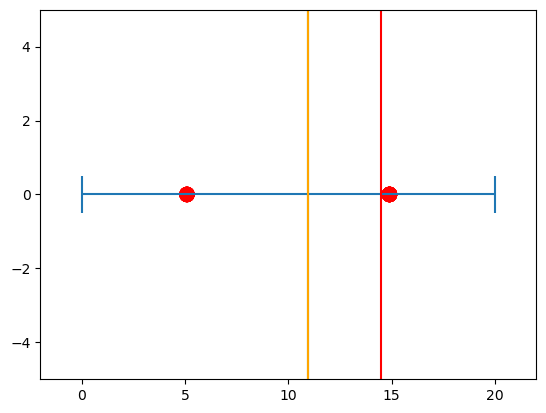

In [70]:
fig,ax = plt.subplots()

ax.set_xlim(-2,22)
ax.set_ylim(-5,5)

# draw lines
xmin = 0
xmax = 20
y1 = 0
height = 1

ax.hlines(y1, xmin, xmax)
ax.vlines(xmin, y1 - height / 2., y1 + height / 2.)
ax.vlines(xmax, y1 - height / 2., y1 + height / 2.)
ax.scatter(coords[:,0],np.zeros(particles), s = np.sqrt(masses)*100, color = 'red')
ax.axvline(MDA_com, color = 'green')
ax.axvline(com_pi, color = 'red')
ax.axvline(corrected_com,color = 'orange')

# ax[1].set_xlim(-2,22)
# ax[1].set_ylim(-5,5)
# ax[1].hlines(y1, xmin, xmax)
# ax[1].vlines(xmin, y1 - height / 2., y1 + height / 2.)
# ax[1].vlines(xmax, y1 - height / 2., y1 + height / 2.)
# ax[1].scatter(wrapped,np.zeros(5),s = np.sqrt(masses)*10, color = 'red')